In [12]:
import os
import logging
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import argparse
import time
import mlflow
import json
import pandas as pd
from qiskit import Aer
from qiskit.algorithms.optimizers import ADAM, COBYLA, SLSQP, NELDER_MEAD, SPSA, L_BFGS_B, GradientDescent
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance
from qiskit_optimization.applications import Maxcut
from qiskit.circuit import Parameter, ParameterVector
from matplotlib.colors import LinearSegmentedColormap



# Custom imports
from haqc.generators.graph_instance import create_graphs_from_all_sources, GraphInstance
from haqc.exp_utils import (
    str2bool,
    to_snake_case,
    make_temp_directory,
    check_boto3_credentials,
)
from haqc.features.graph_features import get_graph_features
from haqc.generators.parameter import get_optimal_parameters
from haqc.solutions.solutions import compute_max_cut_brute_force, compute_distance
from haqc.parallel.landscape_parallel import parallel_computation, parallel_computation_n_layers_fixed
from haqc.initialisation.initialisation import Initialisation
from haqc.plot.utils import *
from haqc.initialisation.parameter_fixing import get_optimal_parameters_from_parameter_fixing

from qiskit.algorithms.optimizers import Optimizer, OptimizerResult
from scipy.optimize import minimize


# Logger setup
logging.basicConfig(
    level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s'
)
qiskit_logger = logging.getLogger('qiskit')
qiskit_logger.setLevel(logging.ERROR)  # or use logging.CRITICAL
logging.info('Script started')

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas.core.frame')

2024-04-12 10:16:50,084 - INFO - Script started


In [13]:
import math
def lookup_optimal_values(graph_type):
    """
    Lookup for optimal beta and gamma values based on the graph type.
    
    Parameters:
    - graph_type: str, describing the type of the graph.
    
    Returns:
    - tuple of (beta, gamma) values if found, otherwise None.
    """
    # Defining the optimal values for each graph type directly as provided
    optimal_values = {
        "2-Regular (ring)": [-math.pi / 8, math.pi / 4],
        "3-Regular (no triangle)": [-math.pi / 8, math.atan(2)],
        "3-Regular Graph": [-0.0904 * math.pi, 0.2209 * math.pi],
        "4-Regular Graph": [-0.4277 * math.pi, -0.1888 * math.pi],
        "Geometric": [-0.0582 * math.pi, -0.8394 * math.pi],
        "Nearly Complete BiPartite": [0.0863 * math.pi, -0.2048 * math.pi],
        "Power Law Tree": [-0.1250 * math.pi, 0.4101 * math.pi],
        "Uniform Random": [0.1104 * math.pi, 0.7751 * math.pi],
        "Watts-Strogatz small world": [0.0703 * math.pi, -0.1807 * math.pi]
    }
    
    return optimal_values.get(graph_type, None)


In [100]:
class OptimiseLayerGreaterThanP(Optimizer):
    """Custom optimizer for QAOA that fixes the first layer's parameters (beta_0, gamma_0) and optimizes the rest using Nelder-Mead."""
    
    def __init__(self, fixed_betas, fixed_gammas):
        """
        Initializes the optimizer with fixed parameters for the first layer's beta and gamma.
        
        Parameters:
            fixed_betas (float): Fixed parameters for beta.
            fixed_gammas (float): Fixed parameters for gamma.
        """
        self.fixed_betas = fixed_betas
        self.fixed_gammas = fixed_gammas
        super().__init__()
    
    def get_support_level(self):
        """Return the support level dictionary indicating gradient and bound support."""
        return {
            'gradient': 0,  # Nelder-Mead does not use gradients
            'bounds': 0,    # Nelder-Mead does not inherently support bounds
            'initial_point': 1,  # Initial points are used
        }
    
    def minimize(self, fun, x0, jac=None, bounds=None):
        """
        Custom minimize function for optimizing only the second set of parameters (beta_1 and gamma_1) using Nelder-Mead.
        """
        
#         if len(x0) > 4:
#             import pdb; pdb.set_trace()
        
        def fun_wrapper(params):
            # Construct the parameter list for the function with fixed and optimized parameters
            # import pdb; pdb.set_trace()
            all_params = np.concatenate([self.fixed_betas, [params[0]], self.fixed_gammas, [params[1]]])
            return fun(all_params)
    
        # Assuming x0[N] and x0[3] are initial guesses for beta_i and gamma_j, respectively
        n_layers = len(x0) // 2
        
        # beta_{n} index
        beta_n_ind = n_layers - 1
        gamma_n_ind = n_layers*2 - 1
        
        initial_guess = [x0[beta_n_ind], x0[gamma_n_ind]]

        # Perform optimization using Nelder-Mead, optimizing only for beta_1 and gamma_1
        result = minimize(fun_wrapper, initial_guess, method='Nelder-Mead')
    
        # Construct the full parameter list with optimized values
        optimized_params = [*self.fixed_betas, result.x[0], *self.fixed_gammas, result.x[1]]

    
        optimizer_result = OptimizerResult()
        optimizer_result.x = optimized_params  # Complete parameter set including fixed and optimized
        optimizer_result.fun = result.fun  # Objective function value at the optimized parameters
        optimizer_result.nfev = result.nfev  # Number of function evaluations
        optimizer_result.success = result.success  # Whether the optimization was successful
    
        return optimizer_result


In [101]:
def build_landscape_plot(
    G, 
    mesh_size: int = 10, 
    beta_lb: float = -2 * np.pi, 
    beta_ub: float = 2 * np.pi, 
    gamma_lb: float = -2 * np.pi, 
    gamma_ub: float = 2 * np.pi,
    layers: int = 1,
    **kwargs
) -> dict:
    """
    Build a landscape plot for the QAOA applied to the Maxcut problem on a given graph.

    Parameters:
    G : networkx.Graph
        The graph for which the QAOA landscape is being computed.
    mesh_size : int
        The number of points in the mesh grid for beta and gamma.
    beta_lb : float, default -2*pi
        The lower bound for the beta parameter.
    beta_ub : float, default 2*pi
        The upper bound for the beta parameter.
    gamma_lb : float, default -2*pi
        The lower bound for the gamma parameter.
    gamma_ub : float, default 2*pi
        The upper bound for the gamma parameter.
    layers : int, default 1
        Number of QAOA layers
        
    Returns:
    dict
        A dictionary containing the beta, gamma, and objective values for the QAOA applied to Maxcut.
    """
    # Convert graph to adjacency matrix and setup Maxcut
    adjacency_matrix = nx.adjacency_matrix(G)
    max_cut = Maxcut(adjacency_matrix)
    qubitOp, offset = max_cut.to_quadratic_program().to_ising()

    # Define QAOA parameters
    beta = ParameterVector('β', length=layers)
    gamma = ParameterVector('γ', length=layers)
    
    # If layers > 1 then fix those layers
    if layers > 1:
        # Check **kwargs if fixed values exist
        if 'fixed_betas' in kwargs and 'fixed_gammas' in kwargs:
            fixed_betas = kwargs['fixed_betas']
            fixed_gammas = kwargs['fixed_gammas']
        else:
            raise TypeError("Provide Fixed Values for Beta and Gamma as a List")
        

    # Initialize the QAOA circuit with the parameters
    qaoa = QAOA(optimizer=SLSQP(), reps=layers, initial_point=[beta, gamma])

    # Create linspace for beta and gamma
    beta_vals = np.linspace(beta_lb, beta_ub, mesh_size)
    gamma_vals = np.linspace(gamma_lb, gamma_ub, mesh_size)
    
    # Check if layers > 1
    if layers > 1:
        print("DOING MORE THAN 1 LAYER")
        obj_vals = parallel_computation_n_layers_fixed(beta_vals, gamma_vals, fixed_betas, fixed_gammas, qubitOp, qaoa)
    else:
        obj_vals = parallel_computation(beta_vals, gamma_vals, qubitOp, qaoa)
    
    return {'beta': beta_vals, 'gamma': gamma_vals, 'obj_vals': obj_vals}

def plot_landscape(landscape_data, ax=None, **kwargs):
    colors = [
        "#0000A3",
        "#7282ee",
        "#B0C7F9",
        "#e2d9d4",
        "#F6BFA6",
        "#de4d4d",
    ]
    custom_cmap = LinearSegmentedColormap.from_list("custom_red_blue_darker_ends", colors, N=256)

    beta = landscape_data['beta'] / np.pi
    gamma = landscape_data['gamma'] / np.pi
    obj_vals = landscape_data['obj_vals']

    # Create a new figure if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        show_colorbar = True
    else:
        show_colorbar = 'colorbar' in kwargs and kwargs['colorbar']

    im = ax.imshow(
        obj_vals.T,
        origin='lower',
        cmap=custom_cmap,
        extent=(beta[0], beta[-1], gamma[0], gamma[-1]),
    )

    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'$\gamma$')

    beta_ticks = np.linspace(beta[0], beta[-1], 5)
    gamma_ticks = np.linspace(gamma[0], gamma[-1], 5)
    ax.set_xticks(beta_ticks)
    ax.set_yticks(gamma_ticks)

    if 'source' in kwargs:
        ax.set_title(kwargs['source'])

    if 'point' in kwargs:
        point = kwargs['point']
        point = (point[0] / np.pi, point[1] / np.pi)
        ax.plot(point[0], point[1], 'r*')

    if show_colorbar:
        plt.colorbar(im, ax=ax)

    if ax is None:
        plt.show()

In [102]:
def adjacency_matrix_to_graph(adj_matrix):
    """Convert an adjacency matrix back to a networkx graph."""
    # Convert the list of lists (adjacency matrix) to a numpy array
    np_matrix = np.array(adj_matrix)
    # Use from_numpy_array since from_numpy_matrix might be deprecated or causing issues
    return nx.from_numpy_array(np_matrix)

In [103]:
json_file_path = "ml-model-landscape.json"
with open(json_file_path, "r") as file:
    data = json.load(file)

instance = data[-1]

In [104]:
seed = 1024182
backend = Aer.get_backend('aer_simulator_statevector')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
# Convert adjacency matrix to graph
G = adjacency_matrix_to_graph(instance["graph"]["adjacency_matrix"])


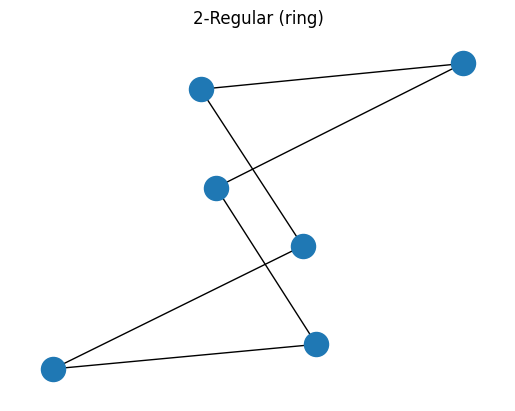

In [105]:
plt.figure()  
plt.title(instance["graph_type"])
nx.draw(G)
plt.show()

In [106]:
# Solving for Exact Ground State using Brute Force for reference
max_cut_partition, max_cut_value = compute_max_cut_brute_force(G)
print(f"MAXCUT Partition: {max_cut_partition}")
print(f"MAXCUT Value: {max_cut_value}")

MAXCUT Partition: (0, 2, 4)
MAXCUT Value: 6


In [122]:
# Placeholder for optimal parameters for each layer
optimal_params = []
MAX_LAYERS = 15  # Maximum number of layers to iterate up to

In [123]:
class OptimizationTracker:
    def __init__(self):
        self.intermediate_values = []
        self.optimizer_name = ""
        self.layer = None
    
    def set_optimizer_name(self, name):
        self.optimizer_name = name
    
    def set_layer(self, layer):
        self.layer = layer

    def store_intermediate_result(self, eval_count, parameters, mean, std):
        self.intermediate_values.append({
            'iteration': eval_count,
            'parameters': parameters,
            'energy': mean,
            'std': std,
            'optimizer': self.optimizer_name,
            'layer': self.layer
        })
        
# Initialize the tracker object outside your optimization loop
tracker = OptimizationTracker()


# List to store the best parameters from the last run of each layer
optimal_params = []

for N_LAYERS in range(2, MAX_LAYERS + 1):
    print(f"\n {'-'*10} Processing {N_LAYERS} layers {'-'*10}\n\n")
    
    tracker.set_layer(N_LAYERS)
    
    if N_LAYERS == 2:
        # For layer 2, fetch initial optimal parameters
        optimal_params_n_layer = lookup_optimal_values(instance["graph_type"])
        print(f"Initial optimal parameters for layer {N_LAYERS}: {optimal_params_n_layer}")
        fixed_betas = [optimal_params_n_layer[0]]
        fixed_gammas = [optimal_params_n_layer[1]]
    else:
        # For layers > 2, use the last optimal parameters from the previous layer
        optimal_params_n_layer = optimal_params[-1]  # Last entry from the optimal parameters list
        print(f"Using best optimized parameters from Layer {N_LAYERS - 1}: {optimal_params_n_layer}")
        half_length = len(optimal_params_n_layer) // 2
        fixed_betas = optimal_params_n_layer[:half_length]
        fixed_gammas = optimal_params_n_layer[half_length:]
    
    ws_init_point = fixed_betas + [np.random.rand()] + fixed_gammas + [np.random.rand()]
    # Define the optimizers for QAOA
    algos_optimizers = [
        ('QAOA', 'Layer-Fix', OptimiseLayerGreaterThanP(
            fixed_betas=fixed_betas, 
            fixed_gammas=fixed_gammas,
        ), None),
        ('QAOA', 'Random', NELDER_MEAD(maxfev=1000), 'random'),
        ('QAOA', 'Layer-WS', NELDER_MEAD(maxfev=1000), ws_init_point)
    ]
    
    for optimizer in algos_optimizers:
        print(f"Solving with {optimizer[1]} strategy")
        
        
        tracker.set_optimizer_name(optimizer[1])
        
        if optimizer[1] == "Random":
            initial_point = np.concatenate([np.random.uniform(-np.pi/4, np.pi/4, N_LAYERS), np.random.uniform(-np.pi, np.pi, N_LAYERS)]).tolist()
        else:
            initial_point = optimizer[3]
            
        
        print(f"Initial Point: {initial_point}")
        
        qaoa = QAOA(
            optimizer=optimizer[2],
            reps=N_LAYERS,
            initial_point=initial_point,
            callback=tracker.store_intermediate_result,  # Use method from the tracker instance
            quantum_instance=quantum_instance
        )
        
        adjacency_matrix = nx.adjacency_matrix(G)
        max_cut = Maxcut(adjacency_matrix)
        qubitOp, offset = max_cut.to_quadratic_program().to_ising()
        qaoa.compute_minimum_eigenvalue(qubitOp)
        
        # Extract the last values (optimal parameters) from the tracker for each optimizer
        last_optimal = tracker.intermediate_values[-1]['parameters']
        min_energy = tracker.intermediate_values[-1]['energy']
        print(f"Minimum energy found {min_energy}")
        print(f"Minimum energy parameters for {optimizer[1]}: {last_optimal}")
        
        
        print(f"Optimization Complete for {optimizer[1]} \n \n \n")
    
    print(f"Solved layer {N_LAYERS} using all techniques")
    layer_n_data = [d for d in tracker.intermediate_values if d['layer'] == N_LAYERS]
    best_result = min(layer_n_data, key=lambda x: x['energy'])
    best_result['parameters'] = best_result['parameters'].tolist()
    print(f"Minimum Energy Found: {best_result['energy']} \n")
    print(json.dumps(best_result, indent=4))
    
    # Update optimal parameters for the current layer with the best results from the last optimizer run
    optimal_params.append(best_result['parameters'])  # Assuming parameters are stored with this key


 ---------- Processing 2 layers ----------


Initial optimal parameters for layer 2: [-0.39269908169872414, 0.7853981633974483]
Solving with Layer-Fix strategy
Initial Point: None
Minimum energy found -1.546981002628155
Minimum energy parameters for Layer-Fix: [-0.39269908  4.77534904  0.78539816  2.28416283]
Optimization Complete for Layer-Fix 
 
 

Solving with Random strategy
Initial Point: [0.49406859379962853, 0.04595244303586732, -3.01363400997791, -1.218869034586595]
Minimum energy found -1.999999994067601
Minimum energy parameters for Random: [ 0.62144437  0.3279407  -3.79749862 -1.24290541]
Optimization Complete for Random 
 
 

Solving with Layer-WS strategy
Initial Point: [-0.39269908169872414, 0.9962557687728433, 0.7853981633974483, 0.8153402917087771]
Minimum energy found -1.9999999715013834
Minimum energy parameters for Layer-WS: [-0.62142782  1.24285377  0.65576247  1.24280839]
Optimization Complete for Layer-WS 
 
 

Solved layer 2 using all techniques
Minimum Energy F

Minimum energy found -2.9999999992710755
Minimum energy parameters for Layer-Fix: [ 0.57418095 -0.08308669 -0.94467038  0.49841453  2.02110085  1.01120184
  1.57078938 -4.01165818 -0.99864216 -3.31117497  2.07504859 -5.90175982
  0.12353542 -0.89710993]
Optimization Complete for Layer-Fix 
 
 

Solving with Random strategy
Initial Point: [-0.3506749614717266, 0.36400080202449714, 0.628745915794118, -0.754091810383893, 0.4911013683160981, 0.05226021068114661, 0.00046961949364243694, 1.758079296799158, -2.941031620039875, 0.553120267120593, 2.5127502959140884, -0.9270086033260156, -1.3215065644680417, 2.3062150569286146]
Minimum energy found -2.9999999991883337
Minimum energy parameters for Random: [-3.14431154e-01  3.04170016e-01  5.94455086e-01 -9.64518411e-01
  4.92700614e-01  5.19148927e-02  4.72988015e-04  1.67120973e+00
 -3.09982204e+00  5.36802475e-01  1.91718757e+00 -1.15795684e+00
 -1.41324351e+00  2.33204790e+00]
Optimization Complete for Random 
 
 

Solving with Layer-WS stra

Minimum energy found -2.9999999992710906
Minimum energy parameters for Layer-Fix: [ 5.74180952e-01 -8.30866899e-02 -9.44670382e-01  4.98414529e-01
  2.02110085e+00  1.01120184e+00  1.57078938e+00 -1.57079632e+00
  3.14159266e+00 -9.97182862e-09 -4.01165818e+00 -9.98642164e-01
 -3.31117497e+00  2.07504859e+00 -5.90175982e+00  1.23535422e-01
 -8.97056125e-01  5.30451285e+00  5.36442624e+00  9.51719227e+00]
Optimization Complete for Layer-Fix 
 
 

Solving with Random strategy
Initial Point: [0.5431335906050025, -0.4500600796818816, 0.3954618004112882, -0.38410701090840726, 0.32358099011452235, 0.2545005517187964, -0.7656108332992215, -0.2773954038002868, -0.5943634003767704, 0.10398543958411821, 1.731494245613126, 1.0768459109329305, 1.3444839680424359, -0.2785979940284773, -1.4933735655200175, 1.4141220165763624, -0.5440323394506223, 3.0193281865390658, 0.3183329543320035, -2.08364235861706]
Minimum energy found -2.999999993768005
Minimum energy parameters for Random: [ 0.37627289 -0.42

Minimum energy found -2.9999997142088777
Minimum energy parameters for Random: [ 0.31024192 -0.61241778 -0.71033118 -0.0535074   0.17079977 -0.58450501
 -0.17212708  0.37636425  0.85709259 -0.2677439  -0.30377549 -0.17656784
 -0.75275348  1.82689126  2.53251123  0.21886772  0.49040085 -3.4509398
 -2.57252941 -2.88596969  3.08037165  0.21303506 -3.10033684 -1.34959556]
Optimization Complete for Random 
 
 

Solving with Layer-WS strategy
Initial Point: [0.5741809516761168, -0.08308668993976479, -0.9446703818383304, 0.49841452899207084, 2.021100848382237, 1.0112018380342465, 1.5707893754158064, -1.5707963193690244, 3.141592657682659, -9.941549348956998e-09, -4.712388981676204, 0.906750815752749, -4.011658184946533, -0.9986421640921839, -3.311174973769447, 2.0750485894743025, -5.901759823546233, 0.12353542151671532, -0.8970561247860578, 5.304512853477645, 5.364426236706588, 9.517274846498106, -1.921015028476904, 0.636325260480097]
Minimum energy found -2.9999999900374634
Minimum energy pa

Minimum energy found -2.9999992345395583
Minimum energy parameters for Random: [-0.27420735 -0.26405199  0.94327777  0.34706439 -0.44812187  0.21100658
 -0.07865592 -0.15153391 -0.45097893 -0.73769908 -0.27338274 -0.78488275
  0.04791454  0.48142246 -1.12648417  0.94317686 -0.01198266 -1.70172961
 -1.12192382 -3.11410337 -2.39422028 -1.35497131  1.79582756  1.89453574
 -1.7852787  -1.09577982  3.4542593  -1.24161741]
Optimization Complete for Random 
 
 

Solving with Layer-WS strategy
Initial Point: [0.5741809516761168, -0.08308668993976479, -0.9446703818383304, 0.49841452899207084, 2.021100848382237, 1.0112018380342465, 1.5707893754158064, -1.5707963193690244, 3.141592657682659, -9.941549348956998e-09, -4.712388981676204, -1.5707963191850802, -3.1415926438580946, 0.6857754697997006, -4.011658184946533, -0.9986421640921839, -3.311174973769447, 2.0750485894743025, -5.901759823546233, 0.12353542151671532, -0.8970561247860578, 5.304512853477645, 5.364426236706588, 9.517274846498106, -1.9

In [124]:
results_df = pd.DataFrame(tracker.intermediate_values)

In [125]:
results_df

,iteration,parameters,energy,std,optimizer,layer
0,1,"[-0.39269908169872414, 4.994564216889232, 0.78...",-0.691846,0.0,Layer-Fix,2
1,2,"[-0.39269908169872414, 5.244292427733694, 0.78...",0.843819,0.0,Layer-Fix,2
2,3,"[-0.39269908169872414, 4.994564216889232, 0.78...",-0.644574,0.0,Layer-Fix,2
3,4,"[-0.39269908169872414, 4.74483600604477, 0.785...",-1.488395,0.0,Layer-Fix,2
4,5,"[-0.39269908169872414, 4.495107795200308, 0.78...",-1.022343,0.0,Layer-Fix,2
...,...,...,...,...,...,...
23294,996,"[0.5680124713060413, -0.08381256413684193, -0....",-2.999999,0.0,Layer-WS,15
23295,997,"[0.5680281552485243, -0.08382462948622993, -0....",-3.000000,0.0,Layer-WS,15
23296,998,"[0.56803891303766, -0.08382195693913089, -0.96...",-2.999999,0.0,Layer-WS,15
23297,999,"[0.5680159287772835, -0.08382018485160861, -0....",-3.000000,0.0,Layer-WS,15


In [126]:
results_df.optimizer.value_counts()

Random       12035
Layer-WS      9830
Layer-Fix     1434
Name: optimizer, dtype: int64

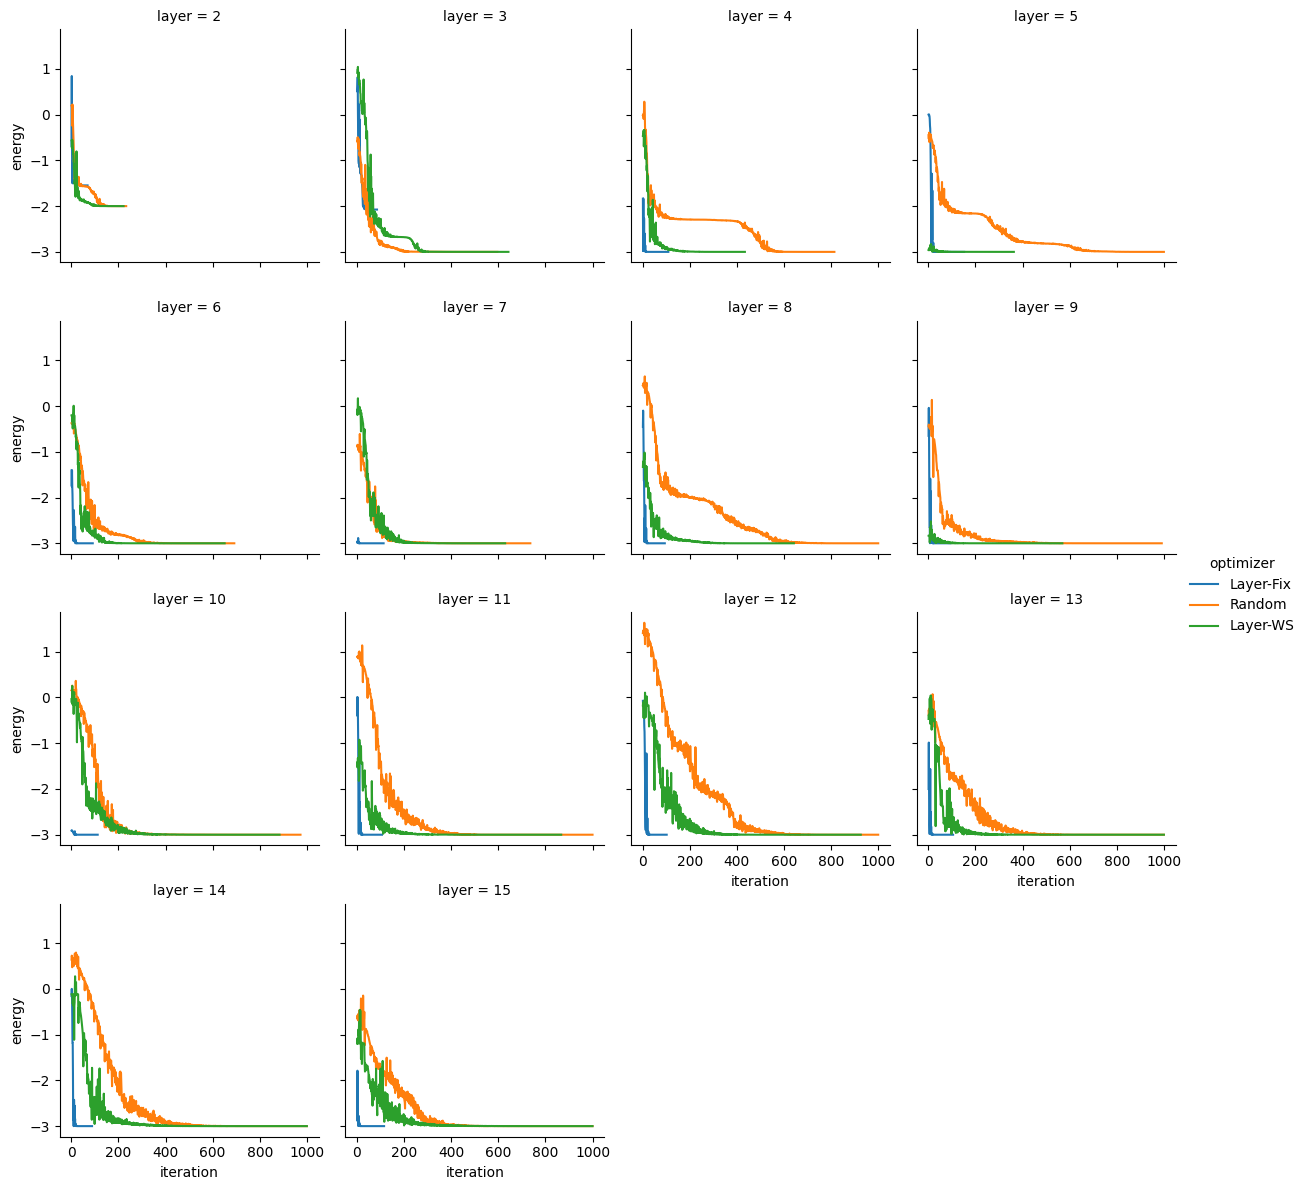

In [127]:
import seaborn as sns

results_df['parameters_str'] = results_df['parameters'].apply(lambda x: ', '.join(map(str, x)))

# Create the FacetGrid
g = sns.FacetGrid(results_df, col='layer', hue='optimizer', col_wrap=4, sharey=True, legend_out=True)
g = g.map(plt.plot, 'iteration', 'energy').add_legend()

for ax in g.axes.flat:
    ax.axhline(y=-3, color='gray', linestyle='--', linewidth=1)

plt.show()

In [133]:
# Group by 'layer' and find the index of the minimum 'energy' in each group
idx_min = results_df.groupby('layer')['energy'].idxmin()
# Extract the rows corresponding to minimum energy and focus on 'parameters' column
min_energy_details = results_df.loc[idx_min, ['parameters', 'optimizer', 'layer']]
print(min_energy_details)

                                              parameters  optimizer
301    [0.6214443734879611, 0.3279407023407033, -3.79...     Random
1847   [0.7853880461791429, 0.3927043356783814, -0.78...   Layer-WS
2769   [0.5966432232587733, -0.08542003482214294, -0....     Random
3343   [0.5966432232587733, -0.08542003482214294, -0....  Layer-Fix
6153   [0.5741809516761168, -0.08308668993976479, -0....   Layer-WS
6253   [0.5741809516761168, -0.08308668993976479, -0....  Layer-Fix
7724   [0.5741809516761168, -0.08308668993976479, -0....  Layer-Fix
9455   [0.5741809516761168, -0.08308668993976479, -0....  Layer-Fix
11122  [0.5741809516761168, -0.08308668993976479, -0....  Layer-Fix
13084  [0.5741809516761168, -0.08308668993976479, -0....  Layer-Fix
15063  [0.5741809516761168, -0.08308668993976479, -0....  Layer-Fix
17074  [0.5741809516761168, -0.08308668993976479, -0....  Layer-Fix
19179  [0.5741809516761168, -0.08308668993976479, -0....  Layer-Fix
21263  [0.5741809516761168, -0.08308668993976479

14

In [138]:
landscape_data_storage = build_landscape_plot(
        G, 
        mesh_size=100, 
        beta_lb=-np.pi/2, 
        beta_ub=np.pi/2, 
        gamma_lb=-np.pi, 
        gamma_ub=np.pi, 
        layers=15,
        fixed_betas=fixed_betas,
        fixed_gammas=fixed_gammas
)

DOING MORE THAN 1 LAYER


Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:29<00:00, 19.61it/s]


# Approach 1 - Optimise only at $p=2$
Lock in 2 parameters as analytical solutions ($\gamma_1$, $\beta_1$) and then optimise only for P=2 parameters ($\gamma_2$ and $\beta_2$)

In [ ]:
for dat in data:
    graph_type = dat["graph_type"]
    beta, gamma = lookup_optimal_values(graph_type=graph_type)
    
    G = adjacency_matrix_to_graph(data[0]["graph"]["adjacency_matrix"])
    # Now, use the retrieved beta and gamma to build landscape data
    landscape_data_storage = build_landscape_plot(
        G, 
        mesh_size=100, 
        beta_lb=-np.pi/2, 
        beta_ub=np.pi/2, 
        gamma_lb=-np.pi, 
        gamma_ub=np.pi, 
        layers=2,
        fixed_betas=[beta],
        fixed_gammas=[gamma]
    )
    
    # Store the generated landscape data under the 'p_2' key in the current dictionary
    dat["landscape_storage_p_2"] = landscape_data_storage

In [ ]:
def numpy_to_python(value):
    """Convert numpy data types to native Python data types for JSON serialization."""
    if isinstance(value, np.ndarray):
        return value.tolist()  # Convert arrays to lists
    elif isinstance(value, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
        return int(value)  # Convert numpy integers to Python int
    elif isinstance(value, (np.float_, np.float16, np.float32, np.float64)):
        return float(value)  # Convert numpy floats to Python float
    else:
        return value  # Return the value unchanged if not a numpy type

def process_landscape_data(landscape_data):
    """Process landscape_data to ensure all numpy types are converted to Python types."""
    for key, value in landscape_data.items():
        landscape_data[key] = numpy_to_python(value)
        
for item in data:
    # Process landscape_data
    if 'landscape_storage_p_2' in item:
        process_landscape_data(item['landscape_storage_p_2'])

In [ ]:
import json

with open('landscape_p_2_data.json', 'w') as f:
    json.dump(data, f)

In [ ]:
# Find the maximum evaluation count for the 'Custom' optimizer
max_eval_count = results_df[results_df['optimizer_name'] == "Random"].eval_count.min()
# Filter for the row with the maximum evaluation count for the 'Custom' optimizer
max_eval_row = results_df[(results_df['optimizer_name'] == "Random") & (results_df['eval_count'] == max_eval_count)]


landscape_data_storage = build_landscape_plot(
    G, 
    mesh_size=20, 
    beta_lb=-np.pi/2, 
    beta_ub=np.pi/2, 
    gamma_lb=-np.pi, 
    gamma_ub=np.pi, 
    layers=2,
    fixed_betas = [max_eval_row.parameters.values[-1][0]],
    fixed_gammas = [max_eval_row.parameters.values[-1][2]]
)

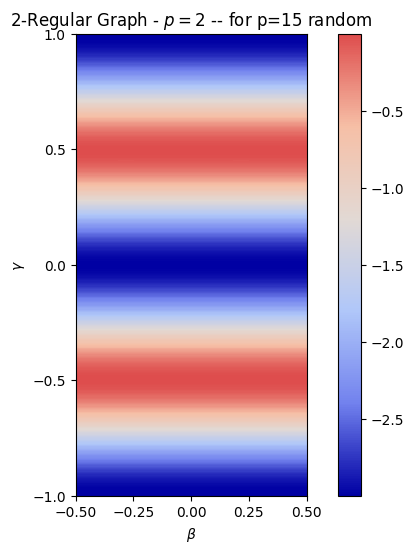

In [139]:
plot_landscape(
    landscape_data_storage, 
#     point = [
#         list(algo_result.optimal_parameters.values())[1]
#         ,list(algo_result.optimal_parameters.values())[3]
#     ], 
    source="2-Regular Graph - $p=2$ -- for p=15 random")

In [ ]:
# Find the maximum evaluation count for the 'Custom' optimizer
max_eval_count = results_df[results_df['optimizer_name'] == "Specific"].eval_count.min()
# Filter for the row with the maximum evaluation count for the 'Custom' optimizer
max_eval_row = results_df[(results_df['optimizer_name'] == "Specific") & (results_df['eval_count'] == max_eval_count)]


landscape_data_storage = build_landscape_plot(
    G, 
    mesh_size=20, 
    beta_lb=-np.pi/2, 
    beta_ub=np.pi/2, 
    gamma_lb=-np.pi, 
    gamma_ub=np.pi, 
    layers=2,
    fixed_betas = [max_eval_row.parameters.values[-1][0]],
    fixed_gammas = [max_eval_row.parameters.values[-1][2]]
)

In [ ]:
plot_landscape(
    landscape_data_storage, 
    point = [
        list(algo_result.optimal_parameters.values())[1]
        ,list(algo_result.optimal_parameters.values())[3]
    ], 
    source="2-Regular Graph - $p=2$ -- for p=1 random")